# Ideal Gas

In [1]:
import numpy as np
from scipy import linalg

import thermoextrap
from thermoextrap import idealgas

import gpflow

from thermoextrap.gpr_active import ig_active
from thermoextrap.gpr_active import active_utils
from thermoextrap.gpr_active import gp_models

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

2022-11-30 16:39:19.510952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wpk/miniforge3/envs/thermoextrap-env/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/wpk/miniforge3/envs/thermoextrap-env/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [2]:
gpflow.__version__

'2.6.3'

## Compare to interpolation

Two key differences with GPR:
  1. No specific functional form is assumed. With polynomial interpolation, you assume (at first derivative order) that a 3rd order polynomial is the exactly correct functional form and compute uncertainty within that assumption. A GP model with an RBF kernel is a universal function approximator, so no specific form is assumed, other than the idea that the function should be smooth on an inferred lengthscale. This leads to greater uncertainty with lower order derivatives because the model is not restricted to any specific order polynomial at any order.
  2. Uncertainties are taken into account when fitting the model. Polynomial interpolation does not weight input data, such as different orders of derivatives, by their uncertainty when using that data for model fitting. GP models can be used for polynomial interpolation and weight information by its uncertainty by using a polynomial kernel. Using an RBF kernel, however, takes us a step further and saves us from needing to select a specific polynomial order, and is infinitely differentiable. Due to its weighting of provided training information by uncertainty, a GP can utilize much higher derivative order information, even becoming more certain in its model fit with high derivative order data.

In [2]:
# Define beta values
beta_list = [0.1, 9.6]

# Create DataWrapper objects that can also be used to build states
wrap_list = [ig_active.IG_DataWrapper(b, seed=None) for b in beta_list]

# Create actual data so consistent when build states with different orders
data_list = [wrap.get_data() for wrap in wrap_list]

/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
202

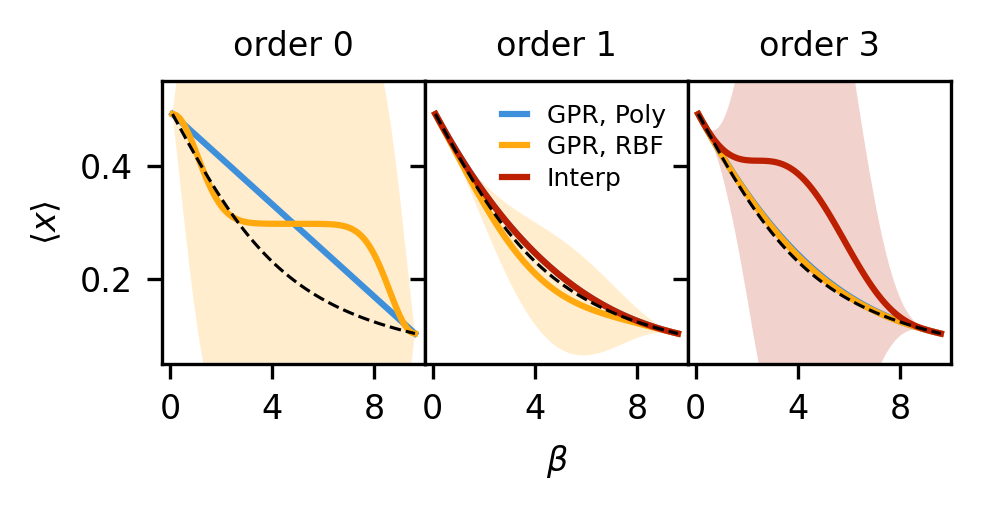

In [3]:
# Plot the results of making predictions with each model
# Idea is to go to higher order and look at effects
d_orders = [0, 1, 3]

test_betas = np.linspace(beta_list[0], beta_list[-1], 100)

fig, ax = plt.subplots(
    1, len(d_orders), sharex=True, sharey=True, figsize=(3.37, 1.8), dpi=300
)

for i, d_o in enumerate(d_orders):
    if d_o == 0:
        m_order = 1
    else:
        m_order = d_o

    # And create states (ExtrapModel objects), using up to max_order derivative orders
    # Order will define what order is used in GP models as well
    this_states = [
        wrap.build_state(all_data=dat, max_order=m_order)
        for (wrap, dat) in zip(wrap_list, data_list)
    ]

    # Create interpolating model
    this_interp = thermoextrap.InterpModel(this_states)

    # Will create two different types of GP models, so just prepare bare inputs here
    # Loop over states and collect information needed for GP
    # Duplicates some code in active_utils.create_GPR(), but want flexibility here to
    # work with different kernels (usually want RBF, so easier then)
    x_data = []
    y_data = []
    cov_data = []
    for s in this_states:
        this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s)
        x_data.append(this_x_data)
        y_data.append(this_y_data)
        cov_data.append(this_cov_data)

    x_data = np.vstack(x_data)
    y_data = np.vstack(y_data)
    noise_cov_mat = linalg.block_diag(*[dat[0, ...] for dat in cov_data])

    if d_o == 0:
        x_data = x_data[::2, :]
        y_data = y_data[::2, :]
        noise_cov_mat = noise_cov_mat[::2, ::2]

    data_input = (x_data, y_data, noise_cov_mat)

    # For purposes of comparing models and comparing to interpolation, best to fix likelihood behavior
    # In other words, don't want to scale variances based on derivative order here
    # Essentially saying that here we trust our uncertainty estimates, so no learning of likelihood params
    # And no modification of covariance matrix
    like_kws = {"p": 0.0, "transform_p": None, "constrain_p": True}

    # Create GP model with default RBF kernel
    this_gp = active_utils.create_base_GP_model(
        data_input,
        likelihood_kwargs=like_kws,
    )
    active_utils.train_GPR(this_gp)

    # And a GP model with a polynomial kernel of order high enough for current derivative order usage
    # Will match order used by interpolation, but will weight uncertainties in Bayesian framework
    poly_kern_info = active_utils.make_poly_expr(2 * d_o + 1)
    poly_kern = gp_models.DerivativeKernel(
        poly_kern_info[0], 1, kernel_params=poly_kern_info[1]
    )
    this_gp_poly = active_utils.create_base_GP_model(
        data_input,
        kernel=poly_kern,
        likelihood_kwargs=like_kws,
    )
    active_utils.train_GPR(this_gp_poly)

    interp_mu = this_interp.predict(test_betas).values
    interp_resamples = this_interp.resample(nrep=1000).predict(test_betas)
    interp_qs = interp_resamples.quantile([0.05, 0.95], dim="rep").values

    gp_mu, gp_var = this_gp.predict_f(
        np.vstack([test_betas, np.zeros_like(test_betas)]).T
    )
    gp_mu = gp_mu.numpy()
    gp_std = np.sqrt(gp_var.numpy())
    gp_qs = np.concatenate([gp_mu - 2.0 * gp_std, gp_mu + 2.0 * gp_std], axis=1)

    gppoly_mu, gppoly_var = this_gp_poly.predict_f(
        np.vstack([test_betas, np.zeros_like(test_betas)]).T
    )
    gppoly_mu = gppoly_mu.numpy()
    gppoly_std = np.sqrt(gppoly_var.numpy())
    gppoly_qs = np.concatenate(
        [gppoly_mu - 2.0 * gppoly_std, gppoly_mu + 2.0 * gppoly_std], axis=1
    )

    ax[i].plot(test_betas, gppoly_mu, label="GPR, Poly")
    ax[i].fill_between(test_betas, gppoly_qs[:, 0], gppoly_qs[:, 1], alpha=0.2)

    ax[i].plot(test_betas, gp_mu, label="GPR, RBF")
    ax[i].fill_between(test_betas, gp_qs[:, 0], gp_qs[:, 1], alpha=0.2)

    if d_o > 0:
        ax[i].plot(test_betas, interp_mu, label="Interp")
        ax[i].fill_between(
            test_betas, interp_qs[0, :, 0], interp_qs[1, :, 0], alpha=0.2
        )

    ax[i].plot(test_betas, idealgas.x_ave(test_betas), "k--", linewidth=0.75)

    ax[i].set_title(r"order %i" % d_o, fontsize=8)
    ax[i].xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
    ax[i].tick_params(axis="both", labelsize=8)

ax[0].set_ylabel(r"$\langle x \rangle$", fontsize=8)
ax[1].set_xlabel(r"$\beta$", fontsize=8)

ax[0].set_xlim((-0.3, 10.0))
ax[0].set_ylim((0.05, 0.55))

ax[1].legend(frameon=False, handlelength=1.0, fontsize=6, labelspacing=0.3)

fig.tight_layout()
fig.subplots_adjust(wspace=0.0)

plt.show()

## Demonstrate active learning

Want to show how it works, mainly. The emphasis here should be on how new points are selected (based on maximum variance) and how that gets us to the desired stopping criteria. For stopping criteria, we want to use two different metrics that must simultaneously reach their desired tolerances. These will be the maximum relative variance predicted by the GP model and the maximum relative deviation since the last update. You need both because the first can become very small if the model becomes prematurely certain of itself - you'll see a jump on the next iteration if this is the case. The second only becomes small when adding new points stops modifiying the function, but we want to do this so that the uncertainty is bounded. The tolerance on the maximum relative function changes partially handles this, but including the maximum predicted relative variance also prevents us from converging just because by chance we got two similar results at a point where the noise is high and we actually want to run more simulations.

### ALM (Maximum variance)



Initial beta values:  [0.1, 9.6]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(



Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.48629    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.59923    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │       

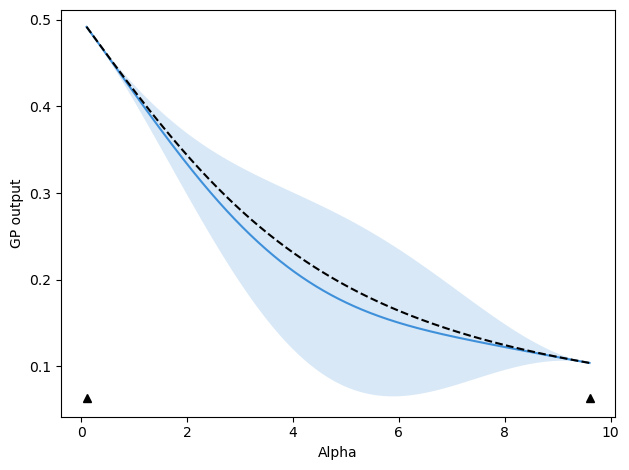


After 1 updates, beta values are: 
[0.1, 9.6, 4.845245245245246]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(



Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 6.87285    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.91891    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │       

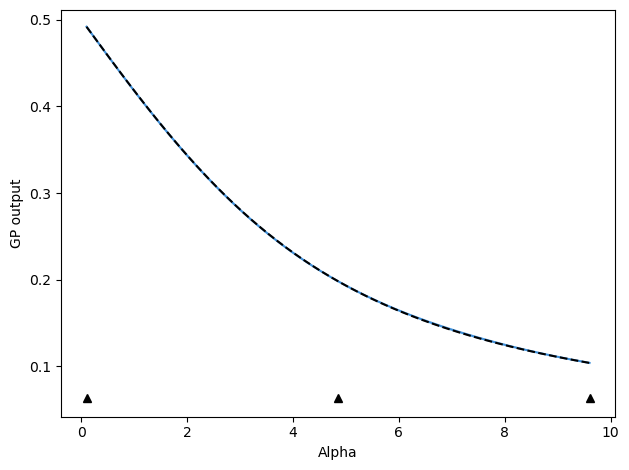


After 2 updates, beta values are: 
[0.1, 9.6, 4.845245245245246, 2.125525525525526]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar


Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.53771     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.81015     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │

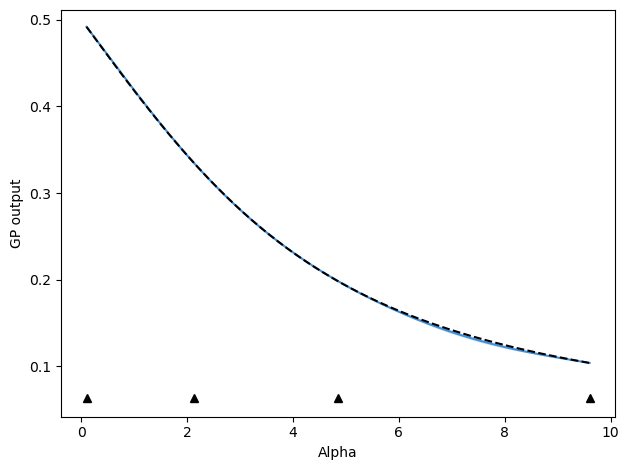


After 3 updates, beta values are: 
[0.1, 9.6, 4.845245245245246, 2.125525525525526, 7.298698698698699]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar


Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 8.69246  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.83743  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │         │ True      

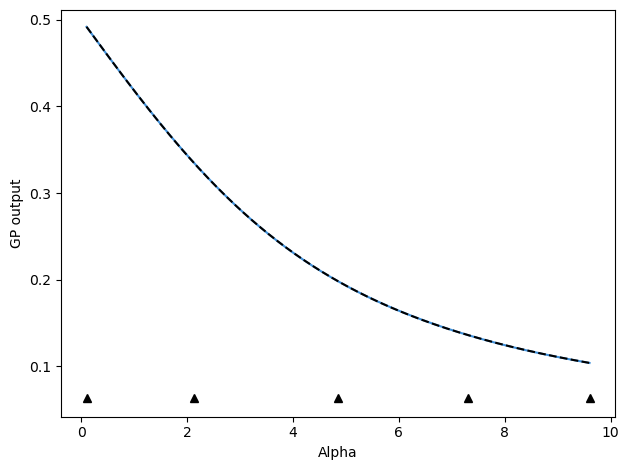


After 4 updates, beta values are: 
[0.1, 9.6, 4.845245245245246, 2.125525525525526, 7.298698698698699, 0.8797797797797798]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar


Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 9.47754  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.85227  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │         │ True      

In [5]:
# Define beta values to start and find function between
beta_list = [0.1, 9.6]

# Set up active learning protocol
deriv_order = 1
sim_protocol = ig_active.SimulateIG()
# Update by selecting point with maximum variance (uncertainty) predicted by model
update_func = active_utils.UpdateALMbrute(
    show_plot=True,
    compare_func=idealgas.x_ave,
)
metrics = [
    active_utils.MaxRelGlobalVar(1e-02),
    active_utils.MaxAbsRelGlobalDeviation(1e-02),
]
stop_func = active_utils.StopCriteria(metrics)

active_list, train_history = active_utils.active_learning(
    beta_list,
    sim_protocol,
    update_func,
    stop_criteria=stop_func,
    max_order=deriv_order,
    alpha_name="beta",
)

/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar

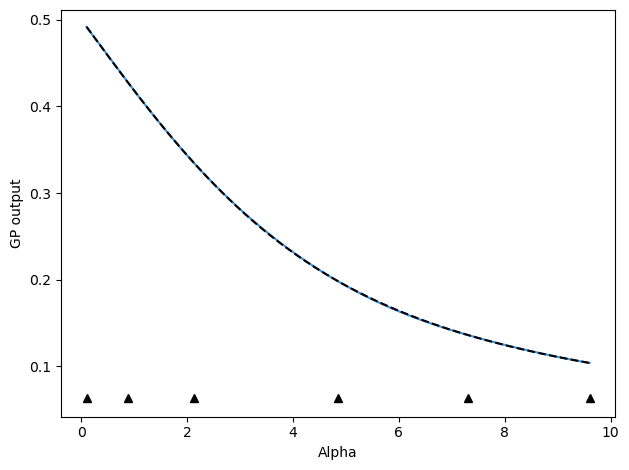

In [6]:
test_betas = np.linspace(beta_list[0], beta_list[-1], 1000)

final_gp = active_utils.create_GPR(
    [dat.build_state(max_order=4) for dat in active_list]
)

final_mu, final_std, final_conf_ints = update_func.get_transformed_GP_output(
    final_gp, test_betas
)

update_func.do_plotting(
    test_betas, final_mu, final_conf_ints, [dat.beta for dat in active_list]
)

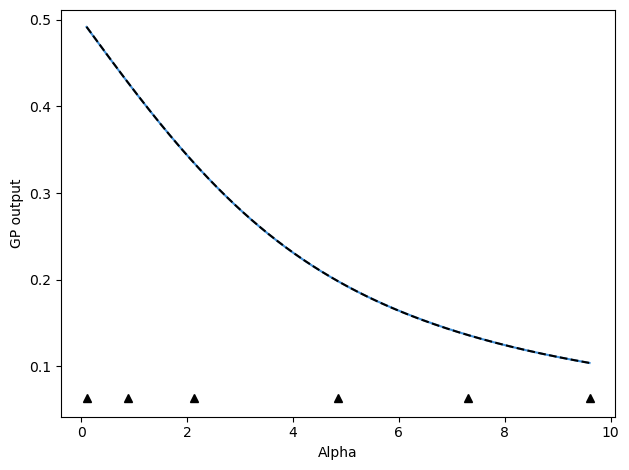

In [7]:
# Or (better) can just plot last stopping criteria history entry
# This gets updated even though plotting with update_func does not happen on last iteration
update_func.do_plotting(
    stop_func.create_alpha_grid(beta_list)[0],
    stop_func.history[0][-1, ...],
    [
        stop_func.history[0][-1, ...] - 2.0 * stop_func.history[1][-1, ...],
        stop_func.history[0][-1, ...] + 2.0 * stop_func.history[1][-1, ...],
    ],
    [dat.beta for dat in active_list],
)

### Space-filling



Initial beta values:  [0.1, 9.6]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(



Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.48709    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.60126    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │       

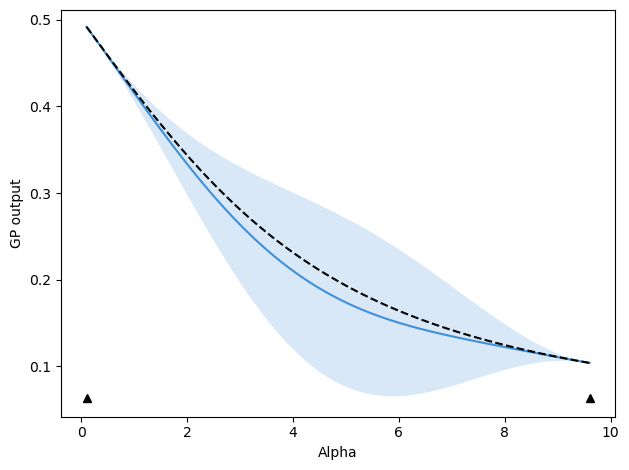


After 1 updates, beta values are: 
[0.1, 9.6, 4.85]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(



Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 6.84885     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.91184     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │

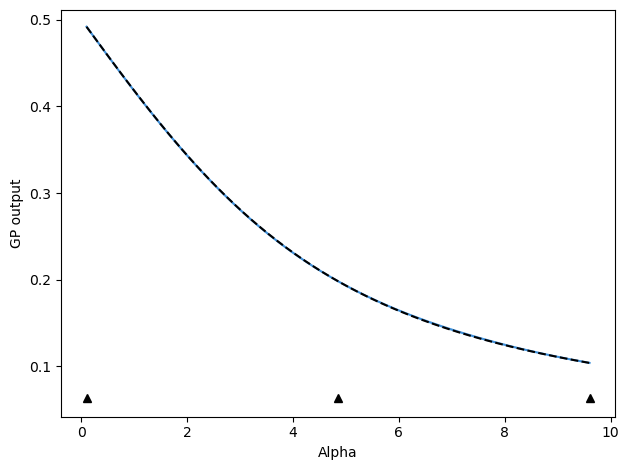


After 2 updates, beta values are: 
[0.1, 9.6, 4.85, 2.475]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar


Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.42482     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 3.84594     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │

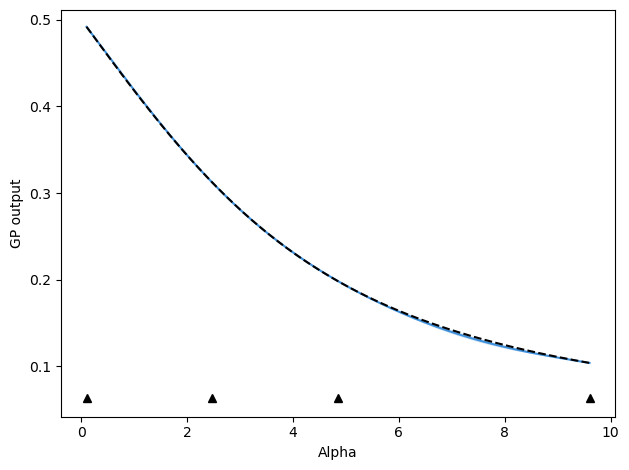


After 3 updates, beta values are: 
[0.1, 9.6, 4.85, 2.475, 7.225]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar


Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 7.66639  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.74589  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │         │ True      

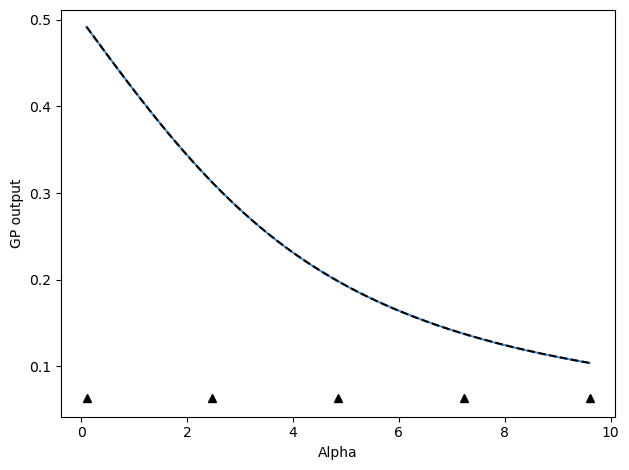


After 4 updates, beta values are: 
[0.1, 9.6, 4.85, 2.475, 7.225, 6.0375]


/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWarning: Using string value for axis is deprecated.  Please use `dim` option instead.  Passed rec of type <class 'str'>
  warn(
/Users/jim2/bin/miniforge3/envs/gpr-active/lib/python3.8/site-packages/cmomy/xcentral.py:66: UserWar


Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 13.9043   │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  5.57992  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Softplus    │         │ Tru

In [8]:
# Define beta values to start and find function between
beta_list = [0.1, 9.6]

# Set up active learning protocol
deriv_order = 1
sim_protocol = ig_active.SimulateIG()
# Update by selecting point with maximum variance (uncertainty) predicted by model
update_func_space = active_utils.UpdateSpaceFill(
    show_plot=True,
    compare_func=idealgas.x_ave,
)
metrics = [
    active_utils.MaxRelGlobalVar(1e-02),
    active_utils.MaxAbsRelGlobalDeviation(1e-02),
]
stop_func_space = active_utils.StopCriteria(metrics)

active_list_space, train_history_space = active_utils.active_learning(
    beta_list,
    sim_protocol,
    update_func_space,
    stop_criteria=stop_func_space,
    max_order=deriv_order,
    alpha_name="beta",
)

### Comparison

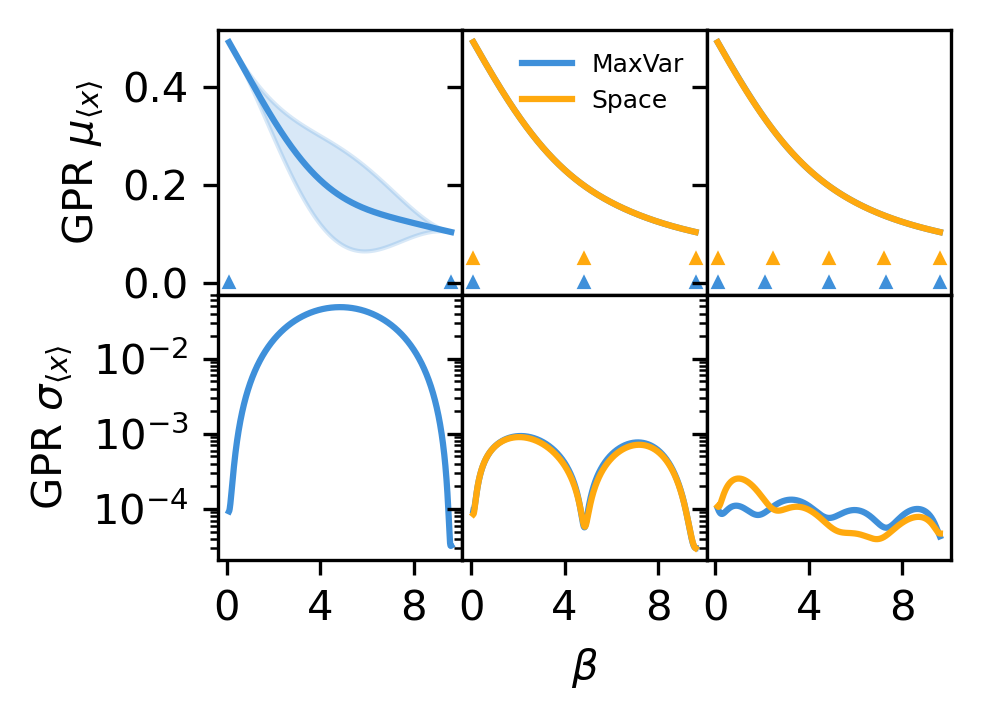

In [9]:
# Or want to plot series of updates to provide sense of how active learning is working
plot_betas = np.linspace(beta_list[0], beta_list[-1], 1000)

update_inds = [0, 1, -1]

fig, ax = plt.subplots(
    2, len(update_inds), sharex=True, sharey="row", figsize=(3.37, 2.5), dpi=300
)

update_colors = ["#3f90da", "#ffa90e"]
update_labels = ["MaxVar", "Space"]

for j, active_info in enumerate(
    zip([stop_func, stop_func_space], [active_list, active_list_space])
):
    this_mu, this_std = active_info[0].history
    this_mu = np.squeeze(this_mu)
    this_std = np.squeeze(this_std)
    this_alpha = np.array([dat.beta for dat in active_info[1]])
    for i, ind in enumerate(update_inds):
        if ind == 0 and j == 1:
            continue
        ax[0, i].plot(
            plot_betas, this_mu[ind, :], color=update_colors[j], label=update_labels[j]
        )
        ax[0, i].fill_between(
            plot_betas,
            this_mu[ind, :] - 2.0 * this_std[ind, :],
            this_mu[ind, :] + 2.0 * this_std[ind, :],
            color=update_colors[j],
            alpha=0.2,
        )
        ax[1, i].plot(
            plot_betas, this_std[ind, :], color=update_colors[j], label=update_labels[j]
        )
        if ind == -1:
            end_ind = -1
        else:
            end_ind = ind + 2
        ax[0, i].plot(
            this_alpha[:end_ind],
            (j * 0.05) * np.ones_like(this_alpha[:end_ind]),
            marker="^",
            markersize=2,
            color=update_colors[j],
            linestyle="",
        )
        ax[0, i].xaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
        ax[0, i].tick_params(axis="both", labelsize=10)
        ax[1, i].tick_params(axis="both", labelsize=10)

ax[0, 1].legend(frameon=False, fontsize=6)

ax[0, 0].set_ylabel(r"GPR $\mu_{\langle x \rangle}$", fontsize=10)
ax[1, 0].set_ylabel(r"GPR $\sigma_{\langle x \rangle}$", fontsize=10)
ax[1, 1].set_xlabel(r"$\beta$", fontsize=10)

ax[1, 0].set_yscale("log")

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()